<h1 style="color:#191970; font-size:38px">MIMO-NN1</h1>

<h1 style="color:#006400">Libraries</h1>

In [1]:
import numpy as np
from numpy.linalg import inv
from commpy.modulation import QAMModem
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
import matplotlib.pyplot as plt
import decimal
from decimal import getcontext

getcontext().Emax = 600000000000

Using TensorFlow backend.


<h1 style="color:#006400">Functions</h1>

In [2]:
import import_ipynb
from Utils import *

importing Jupyter notebook from Utils.ipynb


<h1 style="color:#006400">Variables</h1>

In [3]:
IBO = 3
p = 1.1
q = 4
Vsat = 1.9
G = 16
A = -345
B = 0.17
Mr = 10
Mt = 100
M = 16
N_bits = Mr * np.log2(M)
SNRdb = decimal.Decimal(60000000000)
Niter = 50
mu1 = 0.0017
lamda = 0.00071
mu2 = 1
eps = 1e-2

<h1 style="color:#006400">Initialization</h1>

In [4]:
N_bits = Mr * np.log2(M)
MSE = np.zeros((Mt, 50))
x_gd_amp0 = np.zeros((Mt, 1))
y_gd_r0 = np.zeros([Mt, 100])
PAPR_GD = np.zeros((Mt, 1))
MUIgdi = np.zeros((Mt, 1))
SERgdi = np.zeros((Mt, 1))
BERgdi = np.zeros((Mt, 1))
x_gd = np.zeros([Mt, 1])
gdx1 = np.zeros([Mt, Niter])
d = np.zeros([Mt, 1])
S = np.zeros((1000000, 20))
ZZ = np.zeros((1000000, 10), dtype=complex)
X = np.zeros((1000000, 200))

<h1 style="color:#006400">Basic_Nonlinear_Distortion_Model</h1>

In [5]:
K0, sigma_2d = Basic_Nonlinear_Distortion_Model(A, B, q, p, G, Vsat, IBO)

<h1 style="color:#006400"> Data </h1>

In [6]:
""" Generate the matrix of the channel H ∈ ℂ(Mr * Mt) whose inputs are complex random Gaussian variables
    Transfer H Matrix into a vector that contains H Real values concatenated with H Imaginary values  """
H = (1 / np.sqrt(2 * Mt)) * (np.random.randn(Mr, Mt) + 1j * np.random.randn(Mr, Mt))
HR = H.flatten()
realh = np.real(HR)
imagh = np.imag(HR)
Hr = np.concatenate((realh, imagh), axis=0).reshape(-1, 1)
Hr = np.reshape(Hr, (2000, 1)).T
HH = Hr

In [7]:
"""Generate for each H; 1,000,000 symbols Z and 1,000,000 precoded symbols X by
Generating a random bit stream equivalent to the transmissed signal then modulating this bit stream (16-QAM type modulation) using the QAMModem () function of the CommPy library
Concatenate Z real part with Z imaginary part into S vector its size is (1000000,20)
Compute the gradient gradient in order to have X_gd which, when ampliﬁed and then passed through the channel, can guarantee excellent transmission quality.  
The vector X contains precoded real symbols concatenated with the imaginary ones.
Then update IBO Coefficients where Input Back-Off in a power amplifier, is a measure of how far you must reduce the input power in order to receive the desired output linearity and power.
    Determine the distortion vector (d) and the PA Gain complex (K0) using hpa_sspa_modif_rapp() and find_K0_sigma2_d() functions.
    Where Vin and Vout are the input / output of Power amplifier PA."""
for j in range(1000000):
    bits = np.random.randint(2, size=int(N_bits))  
    QAM16 = QAMModem(16)  
    z = QAM16.modulate(bits)
    Z = np.reshape(z, (1, 10)).T
    ZZ[j] = Z.T
    reals = np.real(Z.T)
    imags = np.imag(Z.T)
    s = np.concatenate((reals, imags), axis=1)
    S[j] = s
    for i in range(Niter):
        gdx1 = 2 * np.conj(K0 * np.transpose(H)).dot(K0 * H.dot(x_gd) + H.dot(d) - Z)
        x_gd = x_gd - mu1 * gdx1
        realx = np.real(x_gd)
        imagx = np.imag(x_gd)
        x_z = np.concatenate((realx, imagx), axis=0).T
        X[j] = x_z
        val_IBO_m1dB = (
            ((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G)
        )
        coeff_IBO_m1dB = (
            val_IBO_m1dB * np.sqrt((1 / np.var(x_gd))) * np.sqrt(10 ** (-IBO / 10))
        )  
        vin2 = coeff_IBO_m1dB * x_gd
        vout2 = hpa_sspa_modif_rapp(
            vin2, Vsat, p, q, G, A, B
        ) 
        K0, sigma2_d = find_K0_sigma2_d(vin2, vout2)
        d = vout2 - K0 * vin2  
        y_gd = np.array(vout2 / coeff_IBO_m1dB)  
       

In [10]:
""" Save S transmitted symbols vector and X precoded symbols vector in datas.npy and datax.npy files """
from numpy import save
save('xdatax.npy', X)
save('sdatas.npy',S)

In [ ]:
""" Load Saved data from datax.npy and datas.npy files instead of runing the hole code above"""
from numpy import load 
X=load('xdata.npy')
S=load('sdata.npy')

In [11]:
"Training dataset"
X_train = S[:900000, :]
y_train = X[:900000, :]
"Test dataset"
X_test = S[900000:, :]
y_test = X[900000:, :]

<h1 style="color:#006400">NN1 Model Architecture</h1>

In [ ]:
keras.optimizers.Adamax(learning_rate=0.9, beta_1=0.999, beta_2=0.999)
model = Sequential()
model.add(
    Dense(units=500, kernel_initializer="uniform", activation="relu", input_dim=20)
)
model.add(
    Dense(units=200, kernel_initializer="uniform", activation="relu")
)
model.add(
    Dense(units=200, kernel_initializer="uniform", activation="selu")
)
model.compile(optimizer="Adamax", loss="mae", metrics=['mse'])
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=1000,
    epochs=1500,
    shuffle=True,
)


Train on 900000 samples, validate on 100000 samples
Epoch 1/1500
900000/900000 [==============================] - 5s 5us/step - loss: 0.0065 - mse: 1.1597e-04 - val_loss: 0.0046 - val_mse: 3.3867e-05
Epoch 2/1500
900000/900000 [==============================] - 5s 5us/step - loss: 0.0043 - mse: 2.9924e-05 - val_loss: 0.0041 - val_mse: 2.7348e-05
Epoch 3/1500
900000/900000 [==============================] - 5s 5us/step - loss: 0.0040 - mse: 2.5999e-05 - val_loss: 0.0039 - val_mse: 2.5109e-05
Epoch 4/1500
900000/900000 [==============================] - 5s 5us/step - loss: 0.0038 - mse: 2.4109e-05 - val_loss: 0.0038 - val_mse: 2.3351e-05
Epoch 5/1500
900000/900000 [==============================] - 5s 5us/step - loss: 0.0037 - mse: 2.2876e-05 - val_loss: 0.0037 - val_mse: 2.2151e-05
Epoch 6/1500
900000/900000 [==============================] - 5s 5us/step - loss: 0.0036 - mse: 2.0970e-05 - val_loss: 0.0035 - val_mse: 1.9753e-05
Epoch 7/1500
900000/900000 [==============================] 

<h1 style="color:#006400"> Loss Representation</h1>

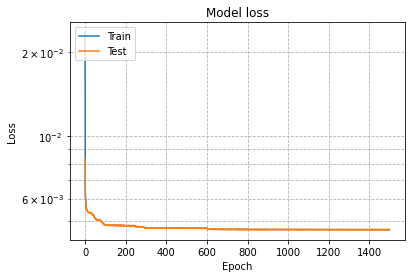

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

<h1 style="color:#006400">NN1 Predictions</h1>

In [27]:
y_pred = model.predict(X_train)
y_predt = model.predict(X_test)

<h1 style="color:#006400">NN1 Weights</h1>

In [ ]:
""" Recovering the weight vector of our model NN1 using the function get_weights ().
    This vector will be the desired output of the NN2 model."""
first_layer_weights =model.layers[0].get_weights()[0] 
first=first_layer_weights.flatten()
first_layer_biases  = model.layers[0].get_weights()[1]
first_layer=np.concatenate((first,first_layer_biases),axis=0)
second_layer_weights = model.layers[1].get_weights()[0]
second=second_layer_weights.flatten()
second_layer_biases  = model.layers[1].get_weights()[1]
second_layer=np.concatenate((second,second_layer_biases),axis=0)
weights=np.concatenate((first_layer,second_layer),axis=0)
print (len(weights))

<h1 style="color:#006400">Simulation Results</h1>

#### Verify test NMSE

In [29]:
NMSE = np.zeros([100000, 1])
recievehh = np.zeros([100000, 10], dtype=complex)
Y_gdr = y_predt[:100000, :100]
Y_gdi = 1j * y_predt[:100000, 100:]
Y_gd = Y_gdr + Y_gdi
Shr = X_test[:100000, :10]
Shi = 1j * X_test[:100000, 10:20]
SSh = Shr + Shi
for i in range(100000):
    val_IBO_m1dB = (
        ((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G)
    )
    coeff_IBO_m1dB = (
        val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd[i]))) * np.sqrt(10 ** (-IBO / 10))
    )
    vin2 = coeff_IBO_m1dB * Y_gd[i]
    vout2 = hpa_sspa_modif_rapp(vin2, Vsat, p, q, G, A, B)
    Y_gd_amp = vout2 / coeff_IBO_m1dB
    recieveh = (H.dot(Y_gd_amp)).reshape((10))
    recievehh[i] = recieveh
    NMSE[i] = np.mean(np.abs(SSh[i] - recieveh) ** 2) / np.mean(np.abs(SSh[i]) ** 2)
    NMSEdb = 10 * np.log10(np.mean(NMSE)) 
print(NMSEdb)

-32.90790375349826
